# Binary classification using Support Vector Machines

One of the classic public datasets used to demonstrate binary classification is the [Titanic dataset](https://www.kaggle.com/c/titanic), which lists 891 of the the passengers aboard the RMS Titanic when it sank on April 15, 1912. The dataset includes the name of each passenger as well as other information such as the fare class, the fare price, the person's age and gender, and whether that person survived the sinking of the ship. In this example, we will build a binary-classification model that predicts whether a passenger will survive. We will use a Support Vector Machine (SVM) classifier as the basis for the model.



## Load and prepare the dataset

The first step is to load the dataset and prepare it for training a machine-learning model. One of the reasons the Titanic dataset is popular is that it provides ample opportunity for data scientists to practice their data-cleaning skills.

In [1]:
import pandas as pd

df = pd.read_csv('Data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Determine whether any of the columns in the dataset are missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Filter the dataset to remove columns that won't be used, one-hot-encode the "Sex" and "Pclass" columns, and remove rows with missing values.

In [3]:
df = df[['Survived', 'Age', 'Sex', 'Pclass']]
df = pd.get_dummies(df, columns=['Sex', 'Pclass'])
df.dropna(inplace=True)
df.head()

,Survived,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,0,1,0,0,1
1,1,38.0,1,0,1,0,0
2,1,26.0,1,0,0,0,1
3,1,35.0,1,0,1,0,0
4,0,35.0,0,1,0,0,1


The next step is to split the data into two datasets: one for training and one for testing. We'll use a stratified split to create a balanced distribution of samples in the training dataset and the testing dataset.

In [4]:
from sklearn.model_selection import train_test_split

x = df.drop('Survived', axis=1)
y = df['Survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

## Build and train an SVM model

Support-vector classifiers (classifiiers that use Support Vector Machines, or SVMs) frequently do better at fitting data than classifiers that rely on logistic regression. Let's try a support-vector classifier on the same dataset and see if it fares better. By default, scikit's `SVC` class does not provide probabilities, but we can ask it to do so by setting its `probability` parameter to `True`. Doing so increases training time, but that's not a big deal here since the dataset is relatively small.

In [5]:
from sklearn.svm import SVC

model = SVC(probability=True, random_state=0)
model.fit(x_train, y_train)

SVC(probability=True, random_state=0)

Get an accuracy score.

In [6]:
model.score(x_test, y_test)

0.5944055944055944

Try a linear kernel and see if the model fares better.

In [7]:
model = SVC(kernel='linear', probability=True, random_state=0)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8321678321678322

Cross-validate the model using five folds.

In [8]:
from sklearn.model_selection import cross_validate

scores = cross_validate(model, x, y, cv=5)
print(scores['test_score'].mean())

0.7801339505564858


## Optimize the model (tune hyperparameters)

We achieved a cross-validated score of 78% using a linear kernel, but we might be able to do better by trying other kernels with a variety of `C` and `gamma` values. Let's use `GridSearchCV` to see if we can improve the model. We'll start with `C` and `gamma` values that range from 0.1 to 10 with three different kernel types.

In [9]:
from sklearn.model_selection import GridSearchCV

model = SVC(probability=True, random_state=0)

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': [0.1, 0.5, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(x, y) # Train the model 75 times with 75 different parameter combinations

best_model = grid_search.best_estimator_ # Get the model with the best performance

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, k

Get the best parameter values from `GridSearchCV`.

In [10]:
print(grid_search.best_params_)

{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}


Cross-validate the model again to see if the score improved.

In [11]:
scores = cross_validate(best_model, x, y, cv=5)
print(scores['test_score'].mean())

0.8179552841524671


We're up from 78% to almost 82% with an RBF kernel. Let's try narrowing the range of `C` and `gamma` and see if we can improve the model further.

In [12]:
model = SVC(kernel='rbf', probability=True, random_state=0)

param_grid = {
    'C': [1, 2, 3],
    'gamma': [0.25, 0.5, 0.75]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(x, y)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................................C=1, gamma=0.25; total time=   0.1s
[CV] END ....................................C=1, gamma=0.25; total time=   0.1s
[CV] END ....................................C=1, gamma=0.25; total time=   0.1s
[CV] END ....................................C=1, gamma=0.25; total time=   0.1s
[CV] END ....................................C=1, gamma=0.25; total time=   0.1s
[CV] END .....................................C=1, gamma=0.5; total time=   0.1s
[CV] END .....................................C=1, gamma=0.5; total time=   0.1s
[CV] END .....................................C=1, gamma=0.5; total time=   0.1s
[CV] END .....................................C=1, gamma=0.5; total time=   0.1s
[CV] END .....................................C=1, gamma=0.5; total time=   0.1s
[CV] END ....................................C=1, gamma=0.75; total time=   0.1s
[CV] END ....................................C=1,

What are the best parameter values this time?

In [13]:
print(grid_search.best_params_)

{'C': 3, 'gamma': 0.25}


And what is the cross-validated score?

In [14]:
scores = cross_validate(best_model, x, y, cv=5)
print(scores['test_score'].mean())

0.8221510883482714


We're above 82% now. Make the best model that `GridSearchCV` found *the* model.

In [15]:
model = best_model

Use a confusion matrix to see how the model performs during testing.

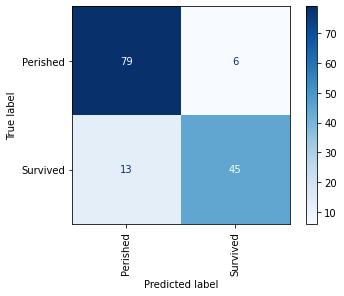

In [16]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, x_test, y_test, display_labels=['Perished', 'Survived'], cmap='Blues', xticks_rotation='vertical')

Print a classification report to view precision, recall, and other metrics.

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        85
           1       0.88      0.78      0.83        58

    accuracy                           0.87       143
   macro avg       0.87      0.85      0.86       143
weighted avg       0.87      0.87      0.87       143



## Use the model to make predictions

Now use the model to predict whether a 30-year-old female traveling in first class will survive the voyage.

In [18]:
female = [[30, 1, 0, 1, 0, 0]]
model.predict(female)[0]

1

More to the point, what is the probability that a 30-year-old female traveling in first class will survive?

In [19]:
probability = model.predict_proba(female)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 84.1%


How about a 60-year-old male traveling in third class?

In [20]:
male = [[60, 0, 1, 0, 0, 1]]
probability = model.predict_proba(male)[0][1]
print(f'Probability of survival: {probability:.1%}')

Probability of survival: 13.0%
